In [ ]:
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████                    | 142.5MB 1.8MB/s eta 0:02:15

In [30]:
!pip install --upgrade tensorflow-gpu


     |████████████████████████████████| 516.2MB 31kB/s 


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import PIL
from tensorflow.keras import layers
import time
from google.colab import drive

from IPython import display


In [3]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
f = np.load('/content/drive/My Drive/Colab Notebooks/MMISEL_GB_train.npy')
print(f.shape)
train_images = np.array([])

(5000, 28, 28)


In [5]:
for i in range(f.shape[0]):
    dist = f[i,:,:]
    dist = dist.flatten()
    if train_images.size == 0:
      train_images = dist
    else:
      train_images = np.vstack((train_images,dist))
print(train_images.shape)

(5000, 784)


In [6]:
train_images = train_images.reshape(train_images.shape[0], 784, 1).astype('float32')
print(np.amax(train_images))
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
print(np.amax(train_images))
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 500

# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 30
noise_dim = 100


254.94388
0.9995598


In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [8]:
def make_1d_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*784, use_bias=False, input_dim=100))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((784, 64)))
    assert model.output_shape == (None, 784, 64) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv1D(32, 5, padding = 'same', use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1D(16, 5, strides = 1, padding = 'same', use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1D(1, 5, strides = 1, padding = 'same', use_bias = False, activation='tanh'))
    assert model.output_shape == (None, 784, 1)

    return model


In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [10]:
def make_1d_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, 5, strides = 2, padding = 'same', input_shape = [784,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, 5, strides = 2, padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_1d = make_1d_generator_model()
discriminator_1d = make_1d_discriminator_model()
generator_1d.summary()
discriminator_1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50176)             5017600   
_________________________________________________________________
batch_normalization_3 (Batch (None, 50176)             200704    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 50176)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 784, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 784, 32)           10240     
_________________________________________________________________
batch_normalization_4 (Batch (None, 784, 32)           128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 784, 32)          

In [13]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/MMISEL_GB_ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

gene_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
discr_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

train_log_dir = '/content/drive/My Drive/Colab Notebooks/logs/train/'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)
    print(tf.shape(images))
    print(images.shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gene_loss(gen_loss)
        discr_loss(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
@tf.function
def train_step_1d(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)
    print(tf.shape(images))
    print(images.shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_1d(noise, training=True)

        real_output = discriminator_1d(images, training=True)
        fake_output = discriminator_1d(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gene_loss(gen_loss)
        discr_loss(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_1d.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_1d.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_1d.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_1d.trainable_variables))

In [16]:
g_loss_t = []
d_loss_t = []
g_loss_v = []
d_loss_v = []


In [17]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        for image_batch in dataset:
            train_step(image_batch)
            batch_no += 1
            if batch_no % 5 == 0:
              print(gene_loss.result().numpy(), discr_loss.result().numpy())
              g_loss_t.append(gene_loss.result().numpy()) 
              d_loss_t.append(discr_loss.result().numpy())
        

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1,  seed)
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gene_loss.result(), step=epoch) 
            tf.summary.scalar('disc_loss', discr_loss.result(), step=epoch)
        
        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
        template = 'Epoch {}, gen_loss: {}, disc_loss: {}'
        print(template.format(epoch+1, gene_loss.result(), discr_loss.result()))
        

        # Reset metrics every epoch
        gene_loss.reset_states()
        discr_loss.reset_states()
    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    checkpoint.save(file_prefix = checkpoint_prefix)
    plt.title('Change in cross-entropy loss during training for MMISEL_GB')
    plt.plot(np.arange(len(g_loss_t)),g_loss_t, label = 'generator')
    plt.plot(np.arange(len(d_loss_t)),d_loss_t, label = 'discriminator')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Train_graph_MMISEL_GB.png')
    plt.show()



In [18]:
def train_1d(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        for image_batch in dataset:
            train_step_1d(image_batch)
            batch_no += 1
            if batch_no % 5 == 0:
              print(gene_loss.result().numpy(), discr_loss.result().numpy())
              g_loss_t.append(gene_loss.result().numpy()) 
              d_loss_t.append(discr_loss.result().numpy())
        

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_1d_images(generator_1d, epoch + 1)
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gene_loss.result(), step=epoch) 
            tf.summary.scalar('disc_loss', discr_loss.result(), step=epoch)
        
        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
        template = 'Epoch {}, gen_loss: {}, disc_loss: {}'
        print(template.format(epoch+1, gene_loss.result(), discr_loss.result()))
        

        # Reset metrics every epoch
        gene_loss.reset_states()
        discr_loss.reset_states()
    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_1d_images(generator_1d, epochs)
    checkpoint.save(file_prefix = checkpoint_prefix)
    plt.title('Change in cross-entropy loss during training for MMISEL_GB')
    plt.plot(np.arange(len(g_loss_t)),g_loss_t, label = 'generator')
    plt.plot(np.arange(len(d_loss_t)),d_loss_t, label = 'discriminator')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Train_graph_MMISEL_GB.png')
    plt.show()



In [19]:
def generate_and_save_images(model, epoch, test_input):
# `training`이 False로 맞춰진 것을 주목하세요.
# 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('/content/drive/My Drive/Colab Notebooks/images/MMISEL_GB_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [20]:
def generate_1d_images(model, epoch):
    noise = tf.random.uniform([4, noise_dim], seed = 1)
    predictions = model(noise, training=False)

    fig = plt.figure()

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.hist(predictions[i,:,0] * 127.5 + 127.5, bins = 128)
        plt.axis('on')
    
    plt.show()

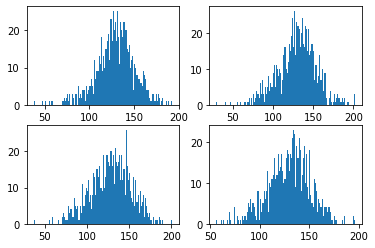

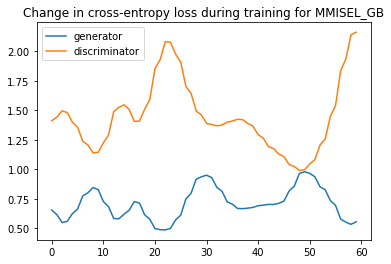

CPU times: user 1min 7s, sys: 7.8 s, total: 1min 15s
Wall time: 2min 5s


In [21]:
%%time
train_1d(train_dataset, EPOCHS)

In [22]:
def valid(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        for image_batch in dataset:
            valid_step(image_batch)
            batch_no += 1
            if batch_no % 5 == 0:
              print(gene_loss.result().numpy(), discr_loss.result().numpy())
              g_loss_v.append(gene_loss.result().numpy()) 
              d_loss_v.append(discr_loss.result().numpy())


        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gene_loss.result(), step=epoch) 
            tf.summary.scalar('disc_loss', discr_loss.result(), step=epoch)
        
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
        template = 'Epoch {}, gen_loss: {}, disc_loss: {}'
        print(template.format(epoch+1, gene_loss.result(), discr_loss.result()))

        # Reset metrics every epoch
        gene_loss.reset_states()
        discr_loss.reset_states()
    # 마지막 에포크가 끝난 후 생성합니다.
    plt.title('Change in cross-entropy loss during validation for MMISEL_GB')
    plt.plot(np.arange(len(g_loss_v)),g_loss_v, label = 'generator')
    plt.plot(np.arange(len(d_loss_v)),d_loss_v, label = 'discriminator')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Colab Notebooks/valid_graph_MMISEL_GB.png')
    plt.show()

In [23]:
def valid_1d(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        for image_batch in dataset:
            valid_step_1d(image_batch)
            batch_no += 1
            if batch_no % 5 == 0:
              print(gene_loss.result().numpy(), discr_loss.result().numpy())
              g_loss_v.append(gene_loss.result().numpy()) 
              d_loss_v.append(discr_loss.result().numpy())


        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gene_loss.result(), step=epoch) 
            tf.summary.scalar('disc_loss', discr_loss.result(), step=epoch)
        
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
        template = 'Epoch {}, gen_loss: {}, disc_loss: {}'
        print(template.format(epoch+1, gene_loss.result(), discr_loss.result()))

        # Reset metrics every epoch
        gene_loss.reset_states()
        discr_loss.reset_states()
    # 마지막 에포크가 끝난 후 생성합니다.
    plt.title('Change in cross-entropy loss during validation for MMISEL_GB')
    plt.plot(np.arange(len(g_loss_v)),g_loss_v, label = 'generator')
    plt.plot(np.arange(len(d_loss_v)),d_loss_v, label = 'discriminator')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Colab Notebooks/valid_graph_MMISEL_GB.png')
    plt.show()

In [24]:
v = np.load('/content/drive/My Drive/Colab Notebooks/MMISEL_GB_valid.npy')
valid_images = np.array([])

In [25]:
for i in range(v.shape[0]):
    dist = v[i,:,:]
    dist = dist.flatten()
    if valid_images.size == 0:
      valid_images = dist
    else:
      valid_images = np.vstack((valid_images,dist))
print(valid_images.shape)

(5000, 784)


In [26]:
valid_images = valid_images.reshape(valid_images.shape[0], 784,1).astype('float32')
valid_images = (valid_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
BUFFER_SIZE = len(valid_images)
BATCH_SIZE = 500

# 데이터 배치를 만들고 섞습니다.
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 30
noise_dim = 100

In [27]:
@tf.function
def valid_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=False)
        real_output = discriminator(images, training=False)
        fake_output = discriminator(generated_images, training=False)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gene_loss(gen_loss)
        discr_loss(disc_loss)


In [28]:
@tf.function
def valid_step_1d(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_1d(noise, training=False)
        real_output = discriminator_1d(images, training=False)
        fake_output = discriminator_1d(generated_images, training=False)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gene_loss(gen_loss)
        discr_loss(disc_loss)


Time for epoch 30 is 0.6430611610412598 sec
Epoch 30, gen_loss: 0.7518936395645142, disc_loss: 1.91372811794281


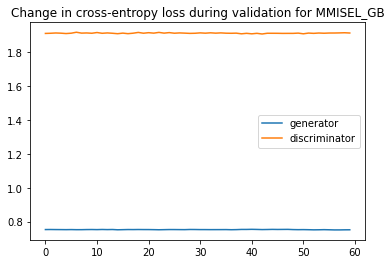

CPU times: user 7.05 s, sys: 2.39 s, total: 9.43 s
Wall time: 20.9 s


In [29]:
%%time
valid_1d(valid_dataset, EPOCHS)

In [30]:
loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
ms = []

In [31]:
@tf.function
def test_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)
    generated_images = generator(noise, training=False)
    print(images, generated_images)
    mse = tf.keras.losses.MSE(generated_images, images)
    loss(mse)



In [32]:
@tf.function
def test_step_1d(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)
    generated_images = generator_1d(noise, training=False)
    print(images, generated_images)
    mse = tf.keras.losses.MSE(generated_images, images)
    loss(mse)

In [33]:
def test(dataset, epochs):
    sum_mse = 0
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        i=0
        for image_batch in dataset:
            test_step(image_batch)
            # print(loss.result().numpy())
            ms.append(loss.result().numpy())
        
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    


    # 마지막 에포크가 끝난 후 생성합니다.
    for i in range(len(ms)):
      sum_mse += ms[i]
    print(sum_mse/len(ms))


In [34]:
def test_1d(dataset, epochs):
    sum_mse = 0
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        i=0
        for image_batch in dataset:
            test_step_1d(image_batch)
            # print(loss.result().numpy())
            ms.append(loss.result().numpy())
        
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    


    # 마지막 에포크가 끝난 후 생성합니다.
    for i in range(len(ms)):
      sum_mse += ms[i]
    print(sum_mse/len(ms))


In [35]:
t = np.load('/content/drive/My Drive/Colab Notebooks/MMISEL_GB_test.npy')
test_images = np.array([])

In [36]:
for i in range(t.shape[0]):
    dist = t[i,:,:]
    dist = dist.flatten()
    if test_images.size == 0:
      test_images = dist
    else:
      test_images = np.vstack((test_images,dist))
print(test_images.shape)

(500, 784)


In [37]:
test_images = test_images.reshape(test_images.shape[0], 784, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
BUFFER_SIZE = len(test_images)
BATCH_SIZE = 50

# 데이터 배치를 만들고 섞습니다.
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

In [38]:
%%time
test_1d(test_dataset,EPOCHS)

Tensor("images:0", shape=(50, 784, 1), dtype=float32) Tensor("sequential_2/conv1d_2/Tanh:0", shape=(50, 784, 1), dtype=float32)
Time for epoch 1 is 0.3193502426147461 sec
Time for epoch 2 is 0.10619282722473145 sec
Time for epoch 3 is 0.10801339149475098 sec
Time for epoch 4 is 0.10300254821777344 sec
Time for epoch 5 is 0.13808822631835938 sec
Time for epoch 6 is 0.11311459541320801 sec
Time for epoch 7 is 0.10150933265686035 sec
Time for epoch 8 is 0.11421036720275879 sec
Time for epoch 9 is 0.10715508460998535 sec
Time for epoch 10 is 0.11718988418579102 sec
0.3253811326622963
CPU times: user 942 ms, sys: 263 ms, total: 1.2 s
Wall time: 1.33 s
